In [1]:
import math
import numpy as np
import random as rand
from numba import jit,int64,float64
import scipy.special as scisp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#The spacetime parameters. Let the population distribution of gene expression level be g:
g_min = 0
g_max = 100
dg = 0.4
#Defining a g_ghost which contains two extra `ghost' points at the edges:
g_ghost = np.arange(g_min-dg,g_max+2*dg,dg)
g = np.array(g_ghost[1:-1])

#Time:
dt = 0.00004
T = 20
Nt = int(T/dt)
TimeRange = np.arange(0,T,dt)

#How the population distributions evolve in the absence of selection. First, we define the free parameters...
#...K and alpha, and from those D. K sets the timescale of population response to the regulated mean...
#...which is set instantaneously. We may choose time units such that K=1.
K = 1
#The strength of noise:
alpha = 2
#The spread, with the preferred expression level (peak) now set to 50% of maximum.:
g_peak = 0.5*(g_min+g_max)
D = alpha*K*g_peak

#Checks:
print(f"K = {K}; 0.5*dg/dt = {0.5*dg/dt}")
print(f"D = {D}; 0.5*dg**2/dt = {0.5*dg**2/dt}")

#Stability check:
flag_stability=0
if (K>=int(0.5*dg/dt) or D>=int(0.5*dg**2/dt)):
    flag_stability=1
    print("Warning! FTCS unstable.")
    
#Now let's add selection to the picture. First, defining the relative differential growth rate delta.
delta = 500/g_max

#Color-blind friendly colors to plot:
CB_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

K = 1; 0.5*dg/dt = 5000.0
D = 100.0; 0.5*dg**2/dt = 2000.0000000000002


In [3]:
#First derivative, central difference method (used in the potential term K*d/dg (g*P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv1(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    #Below we calculate the first derivative using the central difference method:
    derivative = (func_right - func_left)/(2*dx)
    return derivative

#Second derivative using central difference, used in the diffusion term (D*d2/dg2 (P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv2(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    func_center = func[1:-1]
    #Below we calculate the second derivative, again using central difference method:
    derivative2 = (func_right + func_left - 2*func_center)/(dx**2)
    return derivative2

#Defining a Gaussian pdf - we'll need it for P(g,t=0), the initial distribution:
@jit(nopython=True)
def Gaussian_pdf(x,mu,sigma):
    dist = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu)/sigma)**2)
    return dist

#Now the Gaussian cdf:
def Gaussian_cdf(x,mu,sigma):
    param = (x-mu)/sigma
    cum_dist = 0.5*(1 + scisp.erf(param/np.sqrt(2)))
    return cum_dist

#Now we define a truncated Gaussian for the sugar:
def trunc_Gaussian(x,mu,sigma,a,b):
    trunc_gauss = np.zeros_like(x)
    for idx in range(len(x)):
        param = (x[idx]-mu)/sigma
        if (x[idx]<a):
            trunc_gauss[idx] = 0
        elif (a<=x[idx] and x[idx]<=b):
            trunc_gauss[idx] = (1/sigma)*Gaussian_pdf(param,0,1)/(Gaussian_cdf((b-mu)/sigma,0,1) - Gaussian_cdf((a-mu)/sigma,0,1))
        elif (b<x[idx]):
            trunc_gauss[idx] = 0
    return trunc_gauss

#The function to calculate <f> dynamically, i.e. int_g f(g,s) P(g,t):
@jit(nopython=True)
def mean_wrt_P(func,P,g):
    integrand = func*P
    integral = np.trapz(integrand,g)
    return integral

#The function to calculate <f^2> - <f>^2 dynamically:
@jit(nopython=True)
def var_wrt_P(func,P,g):
    term1 = mean_wrt_P(func**2,P,g)
    term2 = (mean_wrt_P(func,P,g))**2
    var = term1 - term2
    return var

#Defining the fitness function:
# @jit(["float64[:](float64[:],float64,float64)","float64(float64,float64,float64)"],nopython=True)
def fitness(g,s,delta):
#     fit = A*(delta*g*s/(C+s) - eta*g/(1-g/M))
    fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))
    return fit

#Putting the solver inside a function:
# @jit("float64[:,:](float64[:],float64[:],float64,float64,float64)",nopython=True)
@jit(nopython=True)
def selection(p0_unreg,p0_reg,s,alpha,delta,g_reg_false,input_var):
    #First, define the fitness function:
    fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))
    
    #Setting g_reg as the false value:
#     g_reg = g[np.argmax(fit)]
    g_reg = g_reg_false

    #Now let's compare the effects of regulation vs selection:
    p_unreg = p0_unreg
    p_reg = p0_reg
    flag_unreg = 0
    flag_reg = 0
    
#     #Storing dynamic fitness:
#     dyn_fit_unreg = np.zeros_like

    #Now evolve it:
    for t in range(Nt):
        #Setting the diffusion constants, unregulated first:
        g_mean_unreg = np.trapz(g*p_unreg,g)
        if (alpha*g_mean_unreg<=1):
            flag_unreg = 1
            D_unreg = 1.1
        elif (alpha*K*g_mean_unreg>=int(0.5*dg**2/dt)):
            flag_unreg = 1
            D_unreg = 0.9*(0.5*dg**2/dt)
        else:
            D_unreg = alpha*K*g_mean_unreg

        #Regulated:
        g_mean_reg = np.trapz(g*p_unreg,g)
        if (alpha*g_mean_reg+input_var<=1):
            flag_reg = 1
            D_reg = 1.1
        elif (alpha*K*g_mean_reg+input_var>=int(0.5*dg**2/dt)):
            flag_reg = 1
            D_reg = 0.9*(0.5*dg**2/dt)
        else:
            D_reg = alpha*K*g_mean_reg + input_var

    #     #Checks:
    #     if (t%10==0):
    #         print(f"\nt={t}; g_mean_unreg={round(g_mean_unreg,2)}; D_unreg={round(D_unreg,2)}; max allowed={0.5*dg**2/dt}")
    #         print(f"t={t}; g_mean_reg={round(g_mean_reg,2)}; D_reg={round(D_reg,2)}; max allowed={0.5*dg**2/dt}")        

        #Now creating the expanded p's, with ghost points. The bulk points are the same in each. Unregulated:
        p_unreg_ghost = np.zeros(len(p_unreg)+2)
        p_unreg_ghost[1:-1] = p_unreg
        #Regulated:
        p_reg_ghost = np.zeros(len(p_reg)+2)
        p_reg_ghost[1:-1] = p_reg

        #Setting the value of the ghost points. This represents the zero flux boundary conditions. Unregulated:
        p_unreg_ghost[0] = p_unreg[1] + 2*dg*(K/D_unreg)*(g[0]-g_peak)*p_unreg[0]
        p_unreg_ghost[-1] = p_unreg[-2] + 2*dg*(K/D_unreg)*(g_peak-g[-1])*p_unreg[-1]
        #Regulated:
        p_reg_ghost[0] = p_reg[1] + 2*dg*(K/D_reg)*(g[0]-g_reg)*p_reg[0]
        p_reg_ghost[-1] = p_reg[-2] + 2*dg*(K/D_reg)*(g_reg-g[-1])*p_reg[-1]    

        #Now to solve the equation. Unregulated first:
        p_unreg = p_unreg + dt*((fit - mean_wrt_P(fit,p_unreg,g))*p_unreg \
                    + K*derv1((g_ghost-g_peak)*p_unreg_ghost,dg) + D_unreg*derv2(p_unreg_ghost,dg))
        p_reg = p_reg + dt*((fit - mean_wrt_P(fit,p_reg,g))*p_reg \
                    + K*derv1((g_ghost-g_reg)*p_reg_ghost,dg) + D_reg*derv2(p_reg_ghost,dg))

#         #Finally, for the edge cases, we normalize:
#         if (flag_unreg==1):
#             p_unreg = p_unreg/np.trapz(p_unreg,dx=dg)
#         if (flag_reg==1):
#             p_reg = p_reg/np.trapz(p_reg,dx=dg)

        #Normalizing:
        p_unreg = p_unreg/np.trapz(p_unreg,dx=dg)
        p_reg = p_reg/np.trapz(p_reg,dx=dg)
            
    return p_unreg,p_reg

#An exponential growth to fit:
def exp_growth(x,a,b,c):
    return np.exp(a*x+b)+c

def poly_7d(x):
    #The best fit of the sug vs g_opt function is 53.60036791981845 + 0.30961110859237373·x¹ + 0.08336445394467541·x² -
    # 0.0065958083037096155·x³ + 0.0002912993947067304·x⁴ -
    # 6.9983138256762474e-06·x⁵ + 9.445898957589526e-08·x⁶ -
    # 6.694023845787639e-10·x⁷ + 1.959288442872537e-12·x⁸. We need its derivative:
    coeff_arr = np.array([0.30961110859237373,2*0.08336445394467541,3*-0.0065958083037096155,4*0.0002912993947067304,5*-6.9983138256762474e-06,\
                         6*9.445898957589526e-08,7*-6.694023845787639e-10,8*1.959288442872537e-12])
    ret_sum = 0
    for idx in range(len(coeff_arr)):
        ret_sum += coeff_arr[idx]*(x**idx)
    return ret_sum

In [4]:
#For a given true value of sugar, the falsely perceived values are distributed as Gaussian with mean equal to the true value...
#...and a s.d. equal to sigma times mean:
sug_low = 53
sug_high = 600
d_sug = 0.1
sug_range = np.arange(sug_low,sug_high,d_sug)

#Now, we know that given what the cell thinks is the sugar, there is a deterministic function that gives us the peak response g_opt:
opt_g = np.zeros_like(sug_range)
g_idx = 0
for s in sug_range:
    fit = fitness(g,s,delta)
    opt_g[g_idx] = g[np.argmax(fit)]
    g_idx+=1
    
#Getting rid of the repeated elements in opt_g and the corresponding elements in sug_range:
opt_g_unq,unq_inds = np.unique(opt_g,return_index=True)
sug_range_unq = sug_range[unq_inds]

In [5]:
#Let's fit the function s(g^*):
from numpy.polynomial import Polynomial
pol_fit = Polynomial.fit(opt_g_unq,sug_range_unq,8,domain=[0,100]).convert()

In [13]:
#Now let's start with a distribution of sugar and find the distribution of g. First, the true sugar and the error in sensing:
sug_true = 400
sigma_sug = 1000

#Setting the sugar pdf (sd not propto mean but constant):
p_sug_false = Gaussian_pdf(sug_range_unq,sug_true,sigma_sug)
p_sug_false = p_sug_false/np.trapz(p_sug_false,dx=d_sug)

# #Setting the sugar pdf (sd propto mean):
# p_sug_false = Gaussian_pdf(sug_range_unq,sug_true,sigma_sug*sug_true)
# p_sug_false = p_sug_false/np.trapz(p_sug_false,dx=d_sug)

#Creating the pdf for g:
pdf_g = np.zeros_like(opt_g_unq)
for g_idx in range(len(opt_g_unq)):
    pdf_g[g_idx] = p_sug_false[g_idx]*poly_7d(opt_g_unq[g_idx])
    
print(np.trapz(p_sug_false,dx=d_sug))
    
#Normalizing:
pdf_g = pdf_g/np.trapz(pdf_g,dx=dg)
print(np.trapz(pdf_g,dx=dg))

0.9999999999999998
1.0000000000000002


In [14]:
# plt.plot(g,pdf_g)
# print(f"mean={mean_wrt_P(opt_g_unq,pdf_g,opt_g_unq)}")
# print(f"var={var_wrt_P(opt_g_unq,pdf_g,opt_g_unq)}")
# # opt_g_unq[np.argmax(pdf_g)]

In [15]:
#Now let's try different values of expression noise alpha vs sigma to see if there's a nontrivial optimum:
alpha = 5
fit = fitness(g,sug_true,delta)
#The 'mean' g_reg is obtained from the perceived sugar:
g_reg_true = g[np.argmax(fit)]
g_reg_false = mean_wrt_P(opt_g_unq,pdf_g,opt_g_unq)
#The variance in g_reg, coming from the variance in input:
input_var = var_wrt_P(opt_g_unq,pdf_g,opt_g_unq)
# g_reg_false = opt_g_unq[np.argmax(pdf_g)]
print(f"g_reg_true={round(g_reg_true,2)}")
print(f"g_reg_false={round(g_reg_false,2)}")

#Generating the initial distributions:
g_peak = 0.5*(g_min+g_max)
#We don't want a standard deviation of 0, so even if the g_reg is 0, we set the s.d. of p0_reg to 1:
p0_unreg = Gaussian_pdf(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
# p0_unreg = np.ones_like(g)
# p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
p0_reg = Gaussian_pdf(g,g_reg_false,np.maximum(np.sqrt(alpha*g_reg_false + input_var),1))
p0_reg = p0_reg/np.trapz(p0_reg,dx=dg)

g_reg_true=92.8
g_reg_false=79.45


In [16]:
# plt.plot(g,p0_reg)
# plt.axvline(g_reg_true,color="k",ls="--")

In [17]:
# alphas = np.logspace(np.log10(0.5),np.log10(5),10)
# for alpha_idx in range(len(alphas)):
#     alpha = alphas[alpha_idx]
    
#     p0_reg = Gaussian_pdf(g,g_reg_false,np.maximum(np.sqrt(alpha*g_reg_false + input_var),1))
#     p0_reg = p0_reg/np.trapz(p0_reg,dx=dg)
    
#     fit_range = np.max(fitness(g,sug_true,delta))-np.min(fitness(g,sug_true,delta))
#     col_fit = (mean_wrt_P(fit,p0_reg,g) - np.min(fitness(g,sug_true,delta)))/fit_range
    
#     print(f"alpha={alpha}; colony fitness={col_fit}")

In [18]:
p_unreg,p_reg = selection(p0_unreg,p0_reg,sug_true,alpha,delta,g_reg_false,input_var)

In [19]:
#Now calculating fitness:
print(f"alpha = {alpha}")
print(f"sigma_sug = {sigma_sug}")
fit_range = np.max(fitness(g,sug_true,delta))-np.min(fitness(g,sug_true,delta))
fit_unreg_unsel = (mean_wrt_P(fit,p0_unreg,g)-np.min(fitness(g,sug_true,delta)))/fit_range
fit_reg_unsel = (mean_wrt_P(fit,p0_reg,g)-np.min(fitness(g,sug_true,delta)))/fit_range
fit_unreg_sel = (mean_wrt_P(fit,p_unreg,g)-np.min(fitness(g,sug_true,delta)))/fit_range
fit_reg_sel = (mean_wrt_P(fit,p_reg,g)-np.min(fitness(g,sug_true,delta)))/fit_range
print(f"fit_unreg_unsel = {round(fit_unreg_unsel,3)}")
print(f"fit_reg_unsel = {round(fit_reg_unsel,3)}")
print(f"fit_unreg_sel = {round(fit_unreg_sel,3)}")
print(f"fit_reg_sel = {round(fit_reg_sel,3)}")

alpha = 5
sigma_sug = 1000
fit_unreg_unsel = 0.688
fit_reg_unsel = 0.834
fit_unreg_sel = 0.968
fit_reg_sel = 0.974


In [20]:
#Start with some sugar levels, which are uniformly distributed:
sugars_arr = np.linspace(80,400,num=5)
p_sugars = np.ones_like(sugars_arr)
p_sugars = p_sugars/np.sum(p_sugars)

#Now, some values of the expression noise alpha:
# alphas = np.logspace(np.log10(0.2),np.log10(5),2)
alphas = np.logspace(np.log10(0.5),np.log10(5),5)
# deltas = np.logspace(-1,np.log10(25),num=6)
sigmas = np.array([10,50,100,200])

#Define the quantities we need. First, colony fitness:
col_fit_unreg_unsel = np.zeros((len(alphas),len(sigmas),len(sugars_arr)))
col_fit_reg_unsel = np.zeros((len(alphas),len(sigmas),len(sugars_arr)))
col_fit_unreg_sel = np.zeros((len(alphas),len(sigmas),len(sugars_arr)))
col_fit_reg_sel = np.zeros((len(alphas),len(sigmas),len(sugars_arr)))

#Fitness across all sugars:
tot_fit_unreg_unsel = np.zeros((len(alphas),len(sigmas)))
tot_fit_reg_unsel = np.zeros((len(alphas),len(sigmas)))
tot_fit_unreg_sel = np.zeros((len(alphas),len(sigmas)))
tot_fit_reg_sel = np.zeros((len(alphas),len(sigmas)))

#To compute mutual information, we use the formula I(g;s) = H(g) - H(g|s). For H(g), we need the marginal...
#...distributions for all four cases:
marg_unreg_unsel = np.zeros((len(alphas),len(sigmas),len(g)))
marg_reg_unsel = np.zeros((len(alphas),len(sigmas),len(g)))
marg_unreg_sel = np.zeros((len(alphas),len(sigmas),len(g)))
marg_reg_sel = np.zeros((len(alphas),len(sigmas),len(g)))

#Then we need the conditional entropies H(g|s). We'll calculate these inside the sugar loop:
condEnt_unreg_unsel = np.zeros((len(alphas),len(sigmas)))
condEnt_reg_unsel = np.zeros((len(alphas),len(sigmas)))
condEnt_unreg_sel = np.zeros((len(alphas),len(sigmas)))
condEnt_reg_sel = np.zeros((len(alphas),len(sigmas)))

#The marginal entropy H(g):
ent_unreg_unsel = np.zeros((len(alphas),len(sigmas)))
ent_reg_unsel = np.zeros((len(alphas),len(sigmas)))
ent_unreg_sel = np.zeros((len(alphas),len(sigmas)))
ent_reg_sel = np.zeros((len(alphas),len(sigmas)))

#Finally, MI as a function of noise:
MI_unreg_unsel = np.zeros((len(alphas),len(sigmas)))
MI_reg_unsel = np.zeros((len(alphas),len(sigmas)))
MI_unreg_sel = np.zeros((len(alphas),len(sigmas)))
MI_reg_sel = np.zeros((len(alphas),len(sigmas)))

In [561]:
for alpha_idx in range(len(alphas)):
    alpha = alphas[alpha_idx]
    for sigma_idx in range(len(sigmas)):
        sigma_sug = sigmas[sigma_idx]
        print(f"\nalpha={alpha}; sigma={sigma_sug}")
        #Defining p0_unreg:
        g_peak = 0.5*(g_min+g_max)
#         p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
        p0_unreg = Gaussian_pdf(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1)).astype('float64')

        #Now looping over sugars:
        for sug_idx in range(len(sugars_arr)):
            #Sugar, fitness function for this sugar and the true g_reg:
            sug_true = sugars_arr[sug_idx]
            fit = fitness(g,sug_true,delta)
            g_reg_true = g[np.argmax(fit)]
            
            #Setting the sugar pdf (sd not propto mean but constant):
            p_sug_false = Gaussian_pdf(sug_range_unq,sug_true,sigma_sug)
            p_sug_false = p_sug_false/np.trapz(p_sug_false,dx=d_sug)
            
#             #Now the pdf of perceived sugar:
#             p_sug_false = Gaussian_pdf(sug_range_unq,sug_true,sigma_sug*sug_true)
#             p_sug_false = p_sug_false/np.trapz(p_sug_false,dx=d_sug)

            #Creating the pdf for g:
            pdf_g = np.zeros_like(opt_g_unq)
            for g_idx in range(len(opt_g_unq)):
                pdf_g[g_idx] = p_sug_false[g_idx]*poly_7d(opt_g_unq[g_idx])
            #Normalizing:
            pdf_g = pdf_g/np.trapz(pdf_g,dx=dg)
            g_reg_false = mean_wrt_P(opt_g_unq,pdf_g,opt_g_unq)
            #The variance in g_reg, coming from the variance in input:
            input_var = var_wrt_P(opt_g_unq,pdf_g,opt_g_unq)
            
            #The fitness range:
            fit_range = np.max(fitness(g,sug_true,delta))-np.min(fitness(g,sug_true,delta))
            
            #Defining p0_reg
#             p0_reg = Gaussian(g,g_reg,np.maximum(np.sqrt(alpha*g_reg),1))
            p0_reg = Gaussian_pdf(g,g_reg_false,np.maximum(np.sqrt(alpha*g_reg_false + input_var),1)).astype('float64')
            p0_reg = p0_reg/np.trapz(p0_reg,dx=dg)

            #Calculating the normalized colony fitness (dividing by max possible fitness, f(g_reg,s)) already for p0_unreg and p0_reg:
            col_fit_unreg_unsel[alpha_idx][sigma_idx][sug_idx] = (mean_wrt_P(fit,p0_unreg,g)-np.min(fitness(g,sug_true,delta)))/fit_range
            col_fit_reg_unsel[alpha_idx][sigma_idx][sug_idx] = (mean_wrt_P(fit,p0_reg,g)-np.min(fitness(g,sug_true,delta)))/fit_range
            #Calculating the marginals for these above two cases:
            marg_unreg_unsel[alpha_idx][sigma_idx] = marg_unreg_unsel[alpha_idx][sigma_idx] + p_sugars[sug_idx]*p0_unreg
            marg_reg_unsel[alpha_idx][sigma_idx] = marg_reg_unsel[alpha_idx][sigma_idx] + p_sugars[sug_idx]*p0_reg
            #Now conditional entropies:
            dummy = np.clip(p0_unreg,0,None)
            dummy = dummy[dummy.nonzero()]
            condEnt_unreg_unsel[alpha_idx][sigma_idx] = condEnt_unreg_unsel[alpha_idx][sigma_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))
            dummy = np.clip(p0_reg,0,None)
            dummy = dummy[dummy.nonzero()]
            condEnt_reg_unsel[alpha_idx][sigma_idx] = condEnt_reg_unsel[alpha_idx][sigma_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))

            #Now running the solver, i.e. letting selection take its course:
            p_unreg,p_reg = selection(p0_unreg,p0_reg,sug_true,alpha,delta,g_reg_false,input_var)

            #Colony fitness for p_unreg and p_reg:
            col_fit_unreg_sel[alpha_idx][sigma_idx][sug_idx] = (mean_wrt_P(fit,p_unreg,g)-np.min(fitness(g,sug_true,delta)))/fit_range
            col_fit_reg_sel[alpha_idx][sigma_idx][sug_idx] = (mean_wrt_P(fit,p_reg,g)-np.min(fitness(g,sug_true,delta)))/fit_range
            print(f"fit_reg_sel[alpha={alpha}][sigma={sigma_sug}][sug={sug_true}]: {col_fit_reg_sel[alpha_idx][sigma_idx][sug_idx]}")
            #Now their marginals:
            marg_unreg_sel[alpha_idx][sigma_idx] = marg_unreg_sel[alpha_idx][sigma_idx] + p_sugars[sug_idx]*p_unreg
            marg_reg_sel[alpha_idx][sigma_idx] = marg_reg_sel[alpha_idx][sigma_idx] + p_sugars[sug_idx]*p_reg        
            #The conditional entropy for p_unreg and p_reg, given by - P(s) sum_g P_reg(g|s) log2 P_reg(g|s):
            dummy = np.clip(p_unreg,0,None)
            dummy = dummy[dummy.nonzero()]
            condEnt_unreg_sel[alpha_idx][sigma_idx] = condEnt_unreg_sel[alpha_idx][sigma_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))
            dummy = np.clip(p_reg,0,None)
            dummy = dummy[dummy.nonzero()]
            condEnt_reg_sel[alpha_idx][sigma_idx] = condEnt_reg_sel[alpha_idx][sigma_idx] - p_sugars[sug_idx]*np.sum(dummy*np.log2(dummy))

        #Ending the sugar loop. First we compute the total fitness across all sugars:
        tot_fit_unreg_unsel[alpha_idx][sigma_idx] = np.sum(col_fit_unreg_unsel[alpha_idx][sigma_idx]*p_sugars)
        tot_fit_reg_unsel[alpha_idx][sigma_idx] = np.sum(col_fit_reg_unsel[alpha_idx][sigma_idx]*p_sugars)
        tot_fit_unreg_sel[alpha_idx][sigma_idx] = np.sum(col_fit_unreg_sel[alpha_idx][sigma_idx]*p_sugars)
        tot_fit_reg_sel[alpha_idx][sigma_idx] = np.sum(col_fit_reg_sel[alpha_idx][sigma_idx]*p_sugars)

        #Now calculating the marginal entropies and information:
        dummy = np.clip(marg_unreg_unsel[alpha_idx][sigma_idx],0,None)
        dummy = dummy[dummy.nonzero()]
        ent_unreg_unsel[alpha_idx][sigma_idx] = -np.sum(dummy*np.log2(dummy))
        MI_unreg_unsel[alpha_idx][sigma_idx] = ent_unreg_unsel[alpha_idx][sigma_idx] - condEnt_unreg_unsel[alpha_idx][sigma_idx]

        dummy = np.clip(marg_reg_unsel[alpha_idx][sigma_idx],0,None)
        dummy = dummy[dummy.nonzero()]
        ent_reg_unsel[alpha_idx][sigma_idx] = -np.sum(dummy*np.log2(dummy))
        MI_reg_unsel[alpha_idx][sigma_idx] = ent_reg_unsel[alpha_idx][sigma_idx] - condEnt_reg_unsel[alpha_idx][sigma_idx]

        dummy = np.clip(marg_unreg_sel[alpha_idx][sigma_idx],0,None)
        dummy = dummy[dummy.nonzero()]
        ent_unreg_sel[alpha_idx][sigma_idx] = -np.sum(dummy*np.log2(dummy))
        MI_unreg_sel[alpha_idx][sigma_idx] = ent_unreg_sel[alpha_idx][sigma_idx] - condEnt_unreg_sel[alpha_idx][sigma_idx]

        dummy = np.clip(marg_reg_sel[alpha_idx][sigma_idx],0,None)
        dummy = dummy[dummy.nonzero()]
        ent_reg_sel[alpha_idx][sigma_idx] = -np.sum(dummy*np.log2(dummy))
        MI_reg_sel[alpha_idx][sigma_idx] = ent_reg_sel[alpha_idx][sigma_idx] - condEnt_reg_sel[alpha_idx][sigma_idx]
        
#Writing to files:
np.savetxt("2b,2_fit_unreg_unsel.txt",tot_fit_unreg_unsel.flatten())
np.savetxt("2b,2_fit_reg_unsel.txt",tot_fit_reg_unsel.flatten())
np.savetxt("2b,2_fit_unreg_sel.txt",tot_fit_unreg_sel.flatten())
np.savetxt("2b,2_fit_reg_sel.txt",tot_fit_reg_sel.flatten())

np.savetxt("2b,2_MI_unreg_unsel.txt",MI_unreg_unsel.flatten())
np.savetxt("2b,2_MI_reg_unsel.txt",MI_reg_unsel.flatten())
np.savetxt("2b,2_MI_unreg_sel.txt",MI_unreg_sel.flatten())
np.savetxt("2b,2_MI_reg_sel.txt",MI_reg_sel.flatten())


alpha=0.5; sigma=10
fit_reg_sel[alpha=0.5][sigma=10][sug=80.0]: 0.9933292199262835
fit_reg_sel[alpha=0.5][sigma=10][sug=160.0]: 0.9902933092678191
fit_reg_sel[alpha=0.5][sigma=10][sug=240.0]: 0.9934513761104821
fit_reg_sel[alpha=0.5][sigma=10][sug=320.0]: 0.9943740647839565
fit_reg_sel[alpha=0.5][sigma=10][sug=400.0]: 0.9957831250071215

alpha=0.5; sigma=50
fit_reg_sel[alpha=0.5][sigma=50][sug=80.0]: 0.9801170042906537
fit_reg_sel[alpha=0.5][sigma=50][sug=160.0]: 0.9604871221715799
fit_reg_sel[alpha=0.5][sigma=50][sug=240.0]: 0.9864628889654764
fit_reg_sel[alpha=0.5][sigma=50][sug=320.0]: 0.9925056067867513
fit_reg_sel[alpha=0.5][sigma=50][sug=400.0]: 0.9952839000919717

alpha=0.5; sigma=100
fit_reg_sel[alpha=0.5][sigma=100][sug=80.0]: 0.9728649241520688
fit_reg_sel[alpha=0.5][sigma=100][sug=160.0]: 0.9426768481852165
fit_reg_sel[alpha=0.5][sigma=100][sug=240.0]: 0.9719029687907959
fit_reg_sel[alpha=0.5][sigma=100][sug=320.0]: 0.9863882675127478
fit_reg_sel[alpha=0.5][sigma=100][sug=4

In [571]:
#Reading from files:
tot_fit_unreg_unsel = np.loadtxt("2b,2_fit_unreg_unsel.txt").reshape(len(alphas),len(sigmas))
tot_fit_reg_unsel = np.loadtxt("2b,2_fit_reg_unsel.txt").reshape(len(alphas),len(sigmas))
tot_fit_unreg_sel = np.loadtxt("2b,2_fit_unreg_sel.txt").reshape(len(alphas),len(sigmas))
tot_fit_reg_sel = np.loadtxt("2b,2_fit_reg_sel.txt").reshape(len(alphas),len(sigmas))

MI_unreg_unsel = np.loadtxt("2b,2_MI_unreg_unsel.txt").reshape(len(alphas),len(sigmas))
MI_reg_unsel = np.loadtxt("2b,2_MI_reg_unsel.txt").reshape(len(alphas),len(sigmas))
MI_unreg_sel = np.loadtxt("2b,2_MI_unreg_sel.txt").reshape(len(alphas),len(sigmas))
MI_reg_sel = np.loadtxt("2b,2_MI_reg_sel.txt").reshape(len(alphas),len(sigmas))

In [572]:
tot_fit_reg_sel

array([[0.99344622, 0.9829713 , 0.97339526, 0.96707883],
       [0.99068112, 0.98116233, 0.97234695, 0.96664129],
       [0.9868498 , 0.9784661 , 0.97146946, 0.9664774 ],
       [0.98170972, 0.97458006, 0.96979318, 0.9661373 ],
       [0.97498434, 0.97039945, 0.96871363, 0.96628289]])

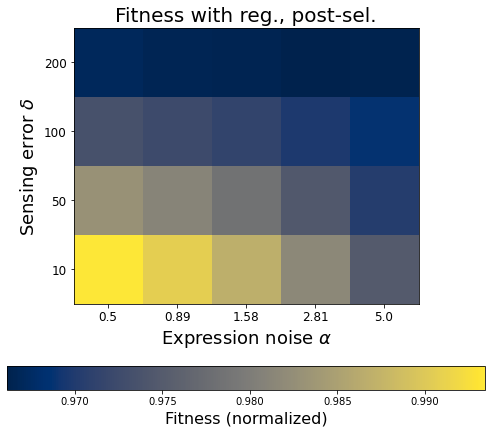

In [573]:
phase_diag = (tot_fit_reg_sel.T)
# cbar_lim = np.maximum(np.abs(np.max(phase_diag)),np.abs(np.min(phase_diag)))
fig,ax = plt.subplots(1,1,figsize=(4.8*1.4,4.2*1.4),constrained_layout='true')
pic=ax.imshow(phase_diag,cmap='cividis',aspect='equal',origin='lower')
cbar = plt.colorbar(pic,orientation="horizontal")
cbar.set_label(r"Fitness (normalized)",fontsize=16)
# plt.xticks(ticks=range(5),labels=np.around(np.logspace(np.log10(0.5),np.log10(5),5),decimals=2))
plt.xticks(ticks=range(5),labels=np.around(alphas,decimals=2))
plt.yticks(ticks=range(4),labels=np.around(sigmas,decimals=1))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r"Expression noise $\alpha$",fontsize=18)
ax.set_ylabel(r"Sensing error $\delta$",fontsize=18)
ax.set_title(f"Fitness with reg., post-sel.",fontsize=20)
# # fig.savefig("2a_fitness_phase_diagram.svg", format="svg")
fig.savefig(fr"2b,2_fitness_reg_sel_vs_alpha_sigma,delta={np.around(delta,2)}.eps", format="eps")

Text(0.5, 1.0, 'Fitness')

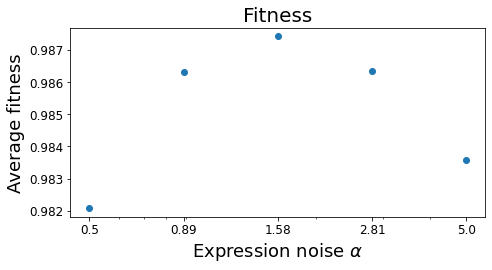

In [78]:
from matplotlib.ticker import FuncFormatter

#x-ticks:
x_ticks = np.around(alphas,2)

fig,ax = plt.subplots(1,1,figsize=(4.8*1.4,2.6*1.4),constrained_layout='true')
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.scatter(alphas,tot_fit_unreg_sel[:,0])
ax.set_xticks(alphas)
ax.set_xticklabels(np.around(alphas,2))
ax.set_xlabel(r"Expression noise $\alpha$",fontsize=18)
ax.set_ylabel(r"Average fitness",fontsize=18)
ax.set_title(f"Fitness",fontsize=20)